In [2]:
import xml.etree.ElementTree as ET
import os
from typing import List
from functools import reduce
from calendar import monthrange
import random
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
import time

## Gender-neutral adjectives describing people

In [4]:
from bs4 import BeautifulSoup
import urllib.request as urllib2
import csv

In [5]:
url = 'https://www.enchantedlearning.com/wordlist/adjectivesforpeople.shtml'
file = urllib2.urlopen(url)
html = file.read()
file.close()
soup = BeautifulSoup(html)

In [6]:
adj = soup.find_all(attrs={"class": "wordlist-item"})

In [7]:
adjs = [x.contents[0] for x in adj]

In [8]:
adjs[:5]

['able', 'abnormal', 'above average', 'absent-minded', 'adventurous']

In [9]:
with open('adjectives.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(adjs)

In [10]:
with open('adjectives.csv') as csv_file:
    adjectives = csv_file.read().split(",")

# Data Parsing and Processing

In [11]:
class Doc:
    def __init__(self, id: int, gdescriptors: List[str], descriptors: List[str], text: str) -> None:
        self.id = id
        self.gdescriptors = gdescriptors
        self.descriptors = descriptors
        self.text = text

In [12]:
def parse_doc(file: str) -> Doc:
    tree = ET.parse(file)
    root = tree.getroot()
    try:
        fulltext = root.find('body').find('body.content').find("*[@class='full_text']")
        text = reduce(lambda x, y: x + y, [x.text for x in fulltext.findall('p')])
        id = int(root.find('head').find('docdata').find('doc-id').attrib['id-string'])
        classifiers = root.find('head').find('docdata').find('identified-content')
        gclassifiers = classifiers.findall("*[@class='online_producer'][@type='general_descriptor']")
        dclassifiers = classifiers.findall("*[@class='online_producer'][@type='descriptor']")
        gdescriptors = [c.text for c in gclassifiers]
        descriptors = [c.text for c in dclassifiers]
        return Doc(id, gdescriptors, descriptors, text)
    except:
        return None

In [13]:
def get_docs_by_month(year: int, month: int) -> List[Doc]:
    days = monthrange(year, month)[1]
    docs = []
    for day in range(1, days+1):
        for file in os.listdir(f'data/{year}/{month:02}/{day:02}/'):
            doc = parse_doc(f'data/{year}/{month:02}/{day:02}/{file}')
            if doc:
                docs.append(doc)
    return docs

In [14]:
t = time.process_time()
all_ = []
for y in range(1988, 2007):
    print(y)
    for i in range(1,13):
        all_ += get_docs_by_month(y, i)
time.process_time() - t

1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


938.044115

In [15]:
len(all_)

1685787

# Saving files locally and loading

In [18]:
with open('alldocs.json', 'w') as outfile:
    json.dump([x.__dict__ for x in all_], outfile)

In [19]:
def save(i, arr):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'w') as outfile:
        json.dump([x.__dict__ for x in arr], outfile)
    print(time.process_time() - t)

In [20]:
def load(i):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'r') as infile:
        l = json.load(infile)
    print(time.process_time() - t)
    return l

In [11]:
save(0, all_[:600000])

26.122622999999976


In [12]:
l0 = load(0)

89.333306


In [13]:
save(1, all_[600000:1200000])

34.060252999999875


In [14]:
l1 = load(1)

102.26382799999988


In [15]:
save(2, all_[1200000:])

31.626627999999982


In [16]:
l2 = load(2)

19.019525000000158


In [17]:
l = l0 + l1 + l2
len(l)

1685787

# Process by descriptor

In [16]:
t = time.process_time()
alld = {}
for doc in all_:
    doc = Doc(doc.id, doc.gdescriptors, doc.descriptors, doc.text)
    for d in doc.descriptors:
        count, docs = alld.get(d, (0, set()))
        docs.add(doc)
        alld[d] = (count + 1, docs)
time.process_time() - t

15.64525100000003

In [17]:
alldlist = sorted([(d, alld[d][0], alld[d][1]) for d in alld], key=lambda x: x[1], reverse=True)
for x in range(15):
    print(alldlist[x][0:2])

('Terrorism', 12393)
('Books and Literature', 11222)
('Politics and Government', 10589)
('Baseball', 9039)
('United States Politics and Government', 8295)
('Motion Pictures', 7748)
('Music', 7317)
('Weddings and Engagements', 7280)
('Medicine and Health', 6829)
('Travel and Vacations', 6537)
('Deaths (Obituaries)', 6438)
('Television', 6171)
('Football', 6070)
('Computers and the Internet', 5952)
('Basketball', 5746)


In [21]:
computers = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld['Computers and the Internet'][1]))

In [23]:
politics = list(filter(lambda x: 'Computers and the Internet' not in x.descriptors, \
                        alld['Politics and Government'][1]))

In [25]:
travel = list(filter(lambda x: 'Politics and Government' not in x.descriptors, \
                        alld['Travel and Vacations'][1]))

In [26]:
len(computers), len(politics), len(travel)

(5825, 10316, 6499)

# Training Word Embeddings

In [27]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [60]:
import nltk

In [63]:
def getw2v(category):
    sentences = []
    for t in category:
        sentences += nltk.sent_tokenize(t.text)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [64]:
t = time.process_time()
mpol = getw2v(politics)
time.process_time() - t

114.42798700000003

In [65]:
t = time.process_time()
mcomp = getw2v(computers)
time.process_time() - t

77.51802599999996

In [66]:
t = time.process_time()
mtrav = getw2v(travel)
time.process_time() - t

107.68803500000013

In [69]:
mpol.wv.most_similar(positive=['approve'], topn=3)

[('submit', 0.8341895937919617),
 ('propose', 0.8119412660598755),
 ('enact', 0.7948086857795715)]

In [70]:
mcomp.wv.most_similar(positive=['approve'], topn=3)

[('impose', 0.7918925285339355),
 ('overturn', 0.7905616760253906),
 ('amend', 0.7885333895683289)]

In [71]:
mtrav.wv.most_similar(positive=['approve'], topn=3)

[('declare', 0.8011578321456909),
 ('succeed', 0.7921991348266602),
 ('reconsider', 0.7868716716766357)]

# Summarization

In [38]:
from gensim.summarization.summarizer import summarize
from gensim.models import LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [39]:
def getsummaries(category):
    s = []
    for i in range(len(category)):
        try:
            s.append(summarize(category[i].text))
        except:
            print(i)
    return s

In [40]:
t = time.process_time()
summaries_pol = getsummaries(politics)
time.process_time() - t

1008
1938
4466
6292
7783
8379
9505
10035


144.86717199999998

In [41]:
t = time.process_time()
summaries_comp = getsummaries(computers)
time.process_time() - t

525
724
2636
2947
3406
4741
4799


107.24657699999989

In [42]:
t = time.process_time()
summaries_trav = getsummaries(travel)
time.process_time() - t

134.83799799999997

In [72]:
def getw2v_s(sums):
    sentences = []
    for t in sums:
        sentences += nltk.sent_tokenize(t)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [73]:
mpols = getw2v_s(summaries_pol)

In [74]:
mcomps = getw2v_s(summaries_comp)

In [75]:
mtravs = getw2v_s(summaries_trav)

# Measuring Bias

In [47]:
with open('debiaswe-master/data/equalize_pairs.json') as f:
    pairs = json.loads(f.read())

In [48]:
from sklearn.decomposition import PCA
from matplotlib.pyplot import bar

In [49]:
pairs = list(map(lambda x: [x[0].lower(), x[1].lower()], pairs))

In [51]:
pairs[:5]

[['monastery', 'convent'],
 ['spokesman', 'spokeswoman'],
 ['catholic_priest', 'nun'],
 ['dad', 'mom'],
 ['men', 'women']]

## For Politics

In [76]:
def getg(m):
    matrix = []
    for a, b in pairs:
        if a not in m.wv.vocab or b not in m.wv.vocab:
            continue
        center = (m.wv.get_vector(a) + m.wv.get_vector(b))/2
        matrix.append(m.wv.get_vector(a) - center)
        matrix.append(m.wv.get_vector(b) - center)
    matrix = np.array(matrix)
    p = PCA(n_components = 10)
    p.fit(matrix)
    bar(range(10), p.explained_variance_ratio_)
    print(matrix.shape)
    return p.components_[0]

(76, 100)


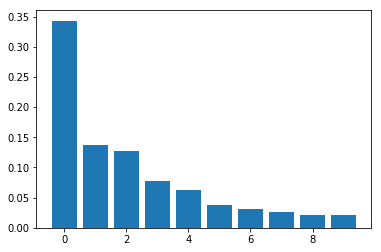

In [77]:
gpol = getg(mpol)

(74, 100)


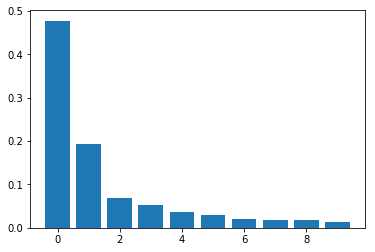

In [78]:
gcomp = getg(mcomp)

(86, 100)


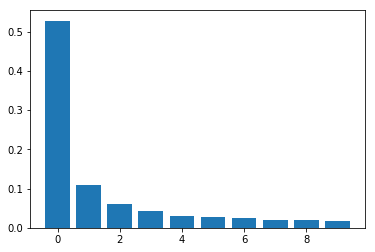

In [79]:
gtrav = getg(mtrav)

(76, 100)


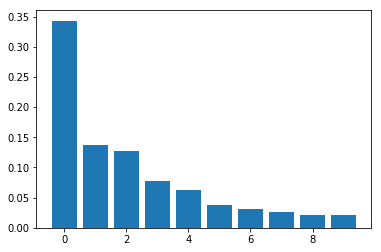

In [119]:
gpols = getg(mpol)

(54, 100)


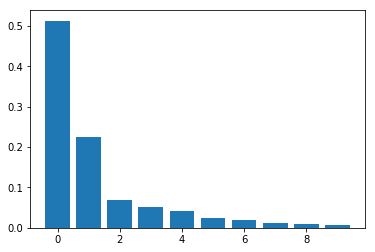

In [120]:
gcomps = getg(mcomps)

(62, 100)


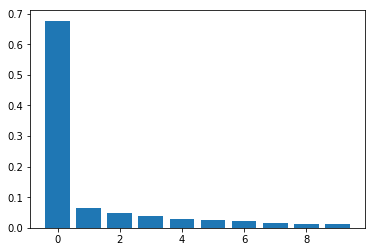

In [121]:
gtravs = getg(mtravs)

<BarContainer object of 10 artists>

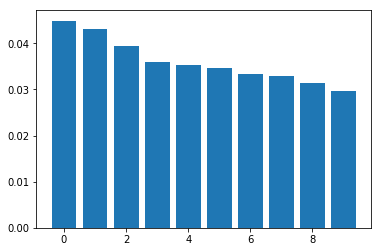

In [96]:
pca_r = PCA(n_components = 10)
pca_r.fit(np.random.rand(76,100))
bar(range(10), pca_r.explained_variance_ratio_)

In [80]:
def gproj(g, m, w1):
    wvec = m.wv.get_vector(w1)
    p = np.dot(g, wvec)/np.linalg.norm(g)
    return p

In [104]:
wordlist = ['he', 'she', 'doctor', 'nurse', 'man', 'woman', 'male', 'female', 'politician', 'guy', \
            'scientist', 'teacher', 'professor', 'mother', 'pretty', 'handsome', 'strong', 'coward', \
            'timid', 'leadership', 'blond', 'lovely', 'petite', 'surgeon', 'physician', 'shopkeeper', \
            'cooking', 'sewing', 'chuckle', 'sassy', 'lanky', 'competent', 'brilliant', 'capable', 'smart', \
            'intelligent', 'incompetent', 'librarian', 'cosmetics', 'maid', 'clever', 'dressed', 'captain', \
            'nanny', 'philosopher', 'architect', 'financier', 'warrior', 'magician', 'housekeeper', 'homemaker']

In [117]:
res = sorted([(x, gproj(gpol, mpol, x)) for x in filter(lambda x: x in mpol.wv.vocab, wordlist)], key=lambda x: x[1])
for i in range(20):
    print(f"{res[i][0].ljust(20)} {res[i][1]} \t\t {res[-i-1][0].ljust(20)} {res[-i-1][1]}")

man                  -3.7426586151123047 		 she                  6.507950782775879
he                   -3.2389204502105713 		 woman                3.978196859359741
leadership           -2.6054000854492188 		 female               2.1559529304504395
professor            -2.5416016578674316 		 male                 2.0371978282928467
politician           -2.009556293487549 		 mother               1.9487175941467285
scientist            -1.995765209197998 		 doctor               1.373782992362976
architect            -1.6636126041412354 		 teacher              1.095907211303711
guy                  -1.236844539642334 		 pretty               1.0189235210418701
captain              -0.7500171065330505 		 dressed              0.6161187887191772
strong               -0.729799747467041 		 blond                0.49705949425697327
financier            -0.48084181547164917 		 intelligent          0.4610220789909363
warrior              -0.3460354208946228 		 smart                0.361495286226272

In [123]:
res = sorted([(x, gproj(gtrav, mtrav, x)) for x in filter(lambda x: x in mtrav.wv.vocab, wordlist)], key=lambda x: x[1])
for i in range(20):
    print(f"{res[i][0].ljust(20)} {res[i][1]} \t\t {res[-i-1][0].ljust(20)} {res[-i-1][1]}")

she                  -6.732553958892822 		 he                   5.921176433563232
woman                -2.8284213542938232 		 architect            2.261176347732544
mother               -1.631007432937622 		 man                  1.9642524719238281
lovely               -0.9345683455467224 		 captain              0.5961882472038269
pretty               -0.8737713694572449 		 guy                  0.5897709727287292
teacher              -0.6393272876739502 		 scientist            0.5507559776306152
blond                -0.6306520104408264 		 professor            0.4121052622795105
dressed              -0.5661043524742126 		 politician           0.24364084005355835
cooking              -0.5366024971008301 		 brilliant            0.23765069246292114
female               -0.41221967339515686 		 doctor               0.21805959939956665
nanny                -0.4005126655101776 		 clever               0.209228515625
nurse                -0.35116928815841675 		 capable              0.200958490371

## Bias measured on list of professions

In [84]:
with open('debiaswe-master/data/professions.json') as f:
    profs = json.loads(f.read())

In [86]:
proflist = list(filter(lambda x: x in mpol.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))

In [132]:
with open('debiaswe-master/data/gender_specific_seed.json') as f:
    gender_specific = json.loads(f.read())

In [136]:
with open('debiaswe-master/data/gender_specific_full.json') as f:
    gender_specific_full = json.loads(f.read())

In [95]:
def bias(g, m, wordlist):
    b = 0
    l = list(filter(lambda x: x in m.wv.vocab, wordlist))
    for x in l:
        b += gproj(g, m, x)**2
    return np.sqrt(b/len(l))

In [103]:
def testbias(wordlist):
    print(f"politics: {bias(gpol, mpol, wordlist)}")
    print(f"politics summary: {bias(gpols, mpols, wordlist)}")
    print(f"computers: {bias(gcomp, mcomp, wordlist)}")
    print(f"computers summary: {bias(gcomps, mcomps, wordlist)}")
    print(f"travel: {bias(gtrav, mtrav, wordlist)}")
    print(f"travel summary: {bias(gtravs, mtravs, wordlist)}")

In [126]:
bias(gpol, mpol, proflist), bias(gpols, mpols, proflist)

(1.080344051949677, 0.7235289508241887)

In [130]:
bias(gpol, mpol, gender_specific), bias(gpols, mpols, gender_specific)

(1.4443633579802266, 0.8515114355018824)

In [122]:
testbias(proflist)

politics: 1.080344051949677
politics summary: 0.7235289508241887
computers: 0.5606665330295195
computers summary: 0.39853296151511014
travel: 0.41046785015210885
travel summary: 0.13200765679855686


In [133]:
testbias(gender_specific)

politics: 1.5975402701761838
politics summary: 0.9180423165261025
computers: 1.4735026773405129
computers summary: 1.0926430491214618
travel: 1.364429929965666
travel summary: 0.9591379027237654


In [134]:
testbias(adjectives)

politics: 0.43647351940669277
politics summary: 0.282504577056523
computers: 0.29300878141766545
computers summary: 0.2200760579903955
travel: 0.3566308922040626
travel summary: 0.17490366763962403


In [135]:
testbias(gender_specific_full)

politics: 1.4443633579802266
politics summary: 0.8515114355018824
computers: 1.346425442116525
computers summary: 1.0266586611981627
travel: 1.1662070490016498
travel summary: 0.8557176663216234


## Regression for bias testing

In [145]:
from random import sample, randint

In [139]:
from scipy import stats

In [140]:
def regress(g1, m1, g2, m2, wordlist):
    x = np.array([gproj(g1, m1, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    y = np.array([gproj(g2, m2, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope, p_value

In [141]:
regress(gpol, mpol, gpols, mpols, proflist)

(0.533629121432331, 1.5349588515623742e-57)

In [142]:
regress(gcomp, mcomp, gcomps, mcomps, proflist)

(-0.47288942755651714, 6.5938456670774195e-21)

In [143]:
regress(gtrav, mtrav, gtravs, mtravs, proflist)

(0.1988740624251196, 4.7826899611645153e-17)

In [147]:
t = time.process_time()
controls_pol = []
count = 0
for i in range(len(politics)):
    if i in [1008, 1938, 4466, 6292, 7783, 8379, 9505, 10035]:
        continue
    n = len(nltk.sent_tokenize(summaries_pol[count]))
    count += 1
    sents_pol = nltk.sent_tokenize(politics[i].text)
    controls_pol += sample(sents_pol, n)
time.process_time() - t

24.0369740000001

In [148]:
t = time.process_time()
docs = [simple_preprocess(s) for s in controls_pol]
mcpol = Word2Vec(docs)
time.process_time() - t

26.502477999999883

(68, 100)


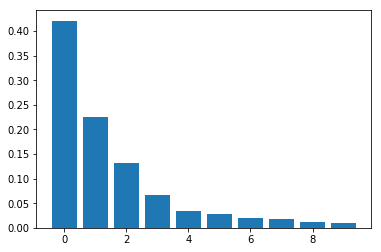

In [149]:
gcpol = getg(mcpol)

In [150]:
bias(gcpol, mcpol, proflist)

0.5980368159429239

In [151]:
words_cpol = []
for s in controls_pol:
    words_cpol += nltk.word_tokenize(s)
len(words_cpol)

2424360

In [152]:
sums_pol = []
for s in summaries_pol:
    sums_pol += nltk.sent_tokenize(s)
len(sums_pol)

72051

In [153]:
words_spol = []
for s in sums_pol:
    words_spol += nltk.word_tokenize(s)
len(words_spol)

3421655

In [154]:
words_pol = []
for p in politics:
    words_pol += nltk.word_tokenize(p.text)
len(words_pol)

10682577

In [156]:
t = time.process_time()
wcontrols_pol = []
count = 0
tot = 0
for i in range(len(politics)):
    if i in [1008, 1938, 4466, 6292, 7783, 8379, 9505, 10035]:
        continue
    # get number of words in the summary
    n = len(nltk.word_tokenize(summaries_pol[count]))
    tot += n
    sents = nltk.sent_tokenize(politics[i].text)
    wcount = 0
    wtot = len(nltk.word_tokenize(politics[i].text))
    start = randint(0, wtot-n)
    end = start + n
    started = False
    for s in sents:
        w = nltk.word_tokenize(s)
        wcount += len(w)
        if wcount < start:
            continue
        elif started is False:  
            wcontrols_pol.append(w[max(0, start-wcount+len(w)-random.randint(1,2)):])
            started = True
        elif wcount > end:
            wcontrols_pol.append(w[:min(len(w), len(w)-wcount+end+2)])
            break
        else:
            wcontrols_pol.append(w)
    # get n-word consecutive subset of original text
    count += 1
time.process_time() - t

151.352848

In [157]:
swcontrols_pol = [" ".join(x) for x in wcontrols_pol]
print(tot, sum([len(x) for x in wcontrols_pol]))

3421595 3471444


In [158]:
t = time.process_time()
docs = [simple_preprocess(s) for s in swcontrols_pol]
mwcpol = Word2Vec(docs)
time.process_time() - t

34.93931199999997

(66, 100)


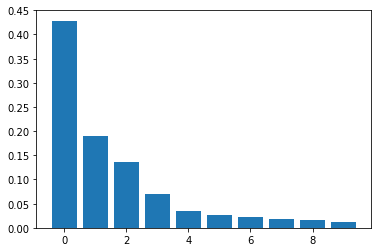

In [159]:
gwcpol = getg(mwcpol)

In [161]:
bias(gwcpol, mwcpol, proflist), bias(gpols, mpols, proflist)

(0.5949498666298728, 0.7235289508241887)

In [162]:
regress(gpols, mpols, gwcpol, mwcpol, proflist)

(-0.76112853809404, 9.301110161945145e-40)

In [163]:
regress(gpol, mpol, gcomp, mcomp, proflist)

(0.28612796610067653, 1.936121103526654e-16)